# Bootstrapping

Implementing a straightforward statistical bootstrap to demonstrate its purpose.

## Bootstrap

Implement a bootstrap method and a simple class that will help us track and plot the results.

In [1]:
from dataclasses import dataclass, field
from typing import Callable, Dict, List, Union

import numpy as np

#### Helpers

In [2]:
choice = np.random.choice
normal = np.random.normal

def metric_func(a: np.ndarray, estimator: Union[str, Callable]) -> Callable[[np.ndarray], float]:
    """the `estimator` can be either an instance method of a numpy array or a user-provided func"""
    is_method = isinstance(estimator, str)
    return lambda a: getattr(a, estimator)() if is_method else estimator(a)

def gen_noise(s, scale=None):
    scale = 2 / s if scale is None else scale
    return normal(scale=scale, size=s)

### Boostrap method

In [30]:
def bootstrap(a: np.ndarray, n: int, estimator: Union[str, Callable], smooth: bool) -> np.ndarray:
    s = a.size  # each set of samples will equal the size of the input set
    b = np.empty(shape=n)  # stores the results of the metric per set of samples
    
    # a small amount (`+-1 / s`) of noise is used to dither the resampling
    noise = gen_noise(s) if smooth else np.float64(0)
    
    # the `estimator` can be either an instance method of a numpy array or a user-provided func
    metric = metric_func(a, estimator)

    # sample with replacement the input set `n` times and apply the estimator to each
    for i in range(n):
        smoothed = choice(a, size=s) + noise
        b[i] = metric(smoothed)

    return b

### Convenience class

This will make it easier to run a bunch of experiments and compare the results in terms of the parameters.

In [4]:
@dataclass
class BootStrap:
    description: str
    dist: Callable[[int], np.ndarray] = field(repr=False)
    m: int
    n: int = 1_000
    est_method: Union[str, Callable] = field(default="mean", repr=False)
    smooth: bool = False
    experiment: np.ndarray = field(default=None, repr=False)

    estimator: str = field(init=False)
    results: np.ndarray = field(init=False, repr=False)

    def __post_init__(self):        
        # friendly estimator name
        self.estimator = self.est_method if isinstance(self.est_method, str) else self.est_method.__name__

        # run the experiment
        self.experiment = self.dist(size=self.m) if self.experiment is None else self.experiment

        # results of applying estimator to each bootstrap
        self.results = bootstrap(
            a=self.experiment,
            n=self.n,
            estimator=self.est_method,
            smooth=self.smooth,
        )

    def to_dict(self) -> Dict[str, List[Union[str, int, float, bool]]]:
        """Tidy form for dataframe use (`n` results from the bootstrap + `n` repeated rows from the source data)."""
        d, exp, n, est, estm, s, m, r = (
            self.description, self.experiment, self.n, self.estimator,
            self.est_method, self.smooth, self.m, self.results
        )
        nrange = lambda v: [v for _ in range(n)]
        return {
            'iter': 2 * list(range(n)),
            'experiment': 2 * nrange(d),
            'samples': 2 * nrange(m),
            'estimator': 2 * nrange(est),
            'source': nrange('samples') + nrange('bootstrap'),
            'smooth': 2 * nrange(s),
            'result': (np.ones(n) * metric_func(exp, estm)(exp)).tolist() + r.tolist(),
        }

BootStrap.__doc__ = """
    ```python
    description: str                          # short description of experimental data
    dist: Callable[[int], np.ndarray]         # func to generate experimental data
    m: int                                    # number of samples in experiment
    n: int = 1_000                            # number of bootstrap resamples to perform
    estimator: Union[str, Callable] = "mean"  # function applied to each bootstrap resample
    smooth: bool = False                      # dither each resample set with a small amount of noise
    experiment: np.ndarray = None             # results of experiment (executed using `dist` if not provided)
    ```
    """

## Evaluate

### Experiments

In [5]:
# boilerplate
uniform, randint = np.random.uniform, np.random.randint
discrete = lambda size: randint(low=-1, high=2, size=size)
discrete.__name__ = "discrete"
ptile90 = lambda a: np.percentile(a, 90)
ptile90.__name__ = "ptile90"

n = 1_500  # number of bootstrap resamples to perform
experiments = [uniform, normal, discrete]
estimators = ['mean', 'std', ptile90, 'min', 'max']
sizes = [100, 10_000]
bargs = [(e.__name__, e, m, n, est, False, None) for e in experiments for m in sizes for est in estimators]

In [6]:
%%time
bootstraps = [BootStrap(*arg) for arg in bargs]
bootstraps += [BootStrap(*arg[:-2], True, b.experiment) for b, arg in zip(bootstraps, bargs)]
print("\n".join([str(b) for b in bootstraps[:3] + ["..."] + bootstraps[-3:]]))
print(f"Total experiments: {len(bootstraps)}")

BootStrap(description='uniform', m=100, n=1500, smooth=False, estimator='mean')
BootStrap(description='uniform', m=100, n=1500, smooth=False, estimator='std')
BootStrap(description='uniform', m=100, n=1500, smooth=False, estimator='ptile90')
...
BootStrap(description='discrete', m=10000, n=1500, smooth=True, estimator='ptile90')
BootStrap(description='discrete', m=10000, n=1500, smooth=True, estimator='min')
BootStrap(description='discrete', m=10000, n=1500, smooth=True, estimator='max')
Total experiments: 60
Wall time: 10.6 s


### Dataframe

Build and preview the dataframe where each row is the result of a single bootstrap resample from our experiments.

In [7]:
import pandas as pd
pd.set_option("display.max_columns", 50)
pd.set_option("max_colwidth", 100)
pd.set_option("display.width", 250)

In [8]:
df = pd.concat([pd.DataFrame(b.to_dict()) for b in bootstraps])
assert np.all(df.groupby(['experiment', 'samples', 'estimator', 'source', 'smooth']).size() == n)
assert np.all(df[(df.smooth == True) & (df.source == 'samples')].groupby(['experiment', 'samples', 'estimator']).result.nunique() == 1)
print(df)

      iter experiment  samples estimator     source  smooth    result
0        0    uniform      100      mean    samples   False  0.486809
1        1    uniform      100      mean    samples   False  0.486809
2        2    uniform      100      mean    samples   False  0.486809
3        3    uniform      100      mean    samples   False  0.486809
4        4    uniform      100      mean    samples   False  0.486809
...    ...        ...      ...       ...        ...     ...       ...
2995  1495   discrete    10000       max  bootstrap    True  1.000868
2996  1496   discrete    10000       max  bootstrap    True  1.000868
2997  1497   discrete    10000       max  bootstrap    True  1.000655
2998  1498   discrete    10000       max  bootstrap    True  1.000868
2999  1499   discrete    10000       max  bootstrap    True  1.000671

[180000 rows x 7 columns]


## Plot Results

How do the bootstrap estimated metrics compare to the same metrics without bootstrapping?

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Helpers

In [23]:
def hist(data, color=None, label=None, *args, **kwargs):
    return sns.distplot(a=data, color=color, label=label, norm_hist=False, hist=True, kde=False, *args, **kwargs)

def plot_facet(df, title: str, *args, **kwargs):
    defaults = [("col", "samples"), ("hue", "source"), ("row", "estimator"), ("height", 3), ("aspect", 1.5), ("sharex", False), ("sharey", False)]
    _ = [kwargs.setdefault(*d) for d in defaults]

    # add a small amount of noise to the original samples result in order to plot as a distribution
    smask = df.source == "samples"
    sdf = df[smask]
    noise = gen_noise(sdf.result.size, 0.001)
    df.loc[smask, "result"] = sdf.result + noise
    
    # plot as a facet grid
    facet = sns.FacetGrid(df, **kwargs)
    facet.map(hist, "result").add_legend()
    plt.subplots_adjust(top=0.93)
    facet.fig.suptitle(title)
    return facet

### estimator(samples) *vs.* estimator(bootstrap)
No smoothing. Rows are the estimation, columns are the number of samples, and the hue compares the estimation of the bootstrap to the original samples.

*Note: a small amount of noise is after the estimator is applied to original samples so that it can be seen in the histograms.*

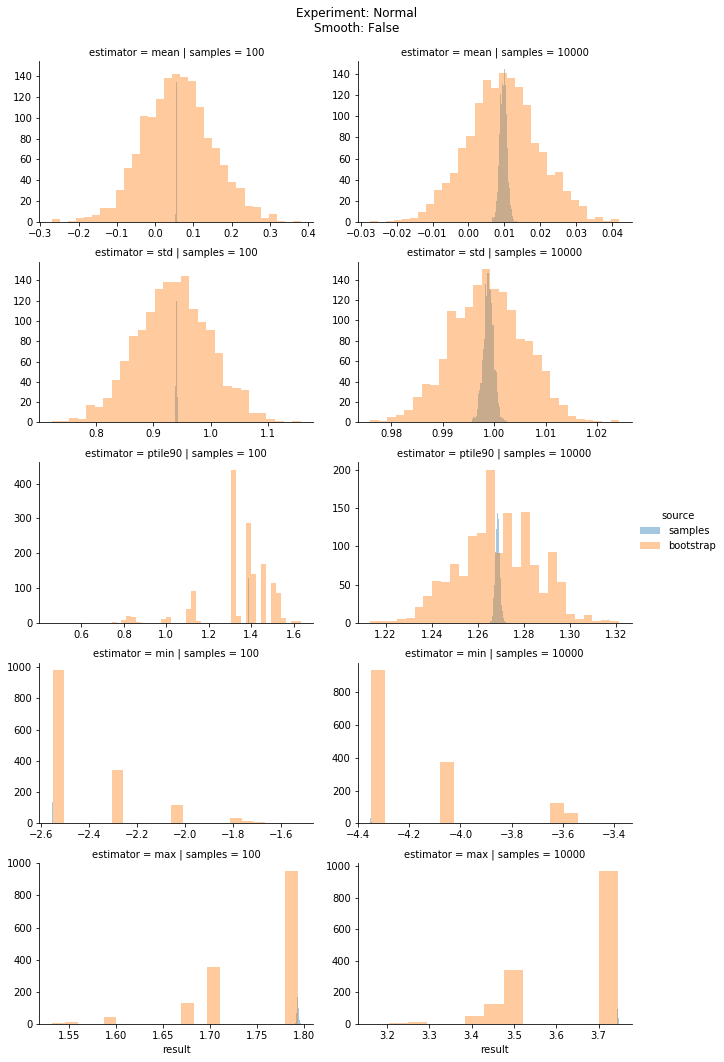

In [24]:
smooth = False
pdf = df[(df.experiment == "normal") & (df.smooth == smooth)]
g = plot_facet(pdf, f"Experiment: Normal\nSmooth: {smooth}")

In [25]:
pdf = df[(df.experiment == "uniform") & (df.smooth == smooth)]
g = plot_facet(pdf, f"Experiment: Uniform\nSmooth: {smooth}")

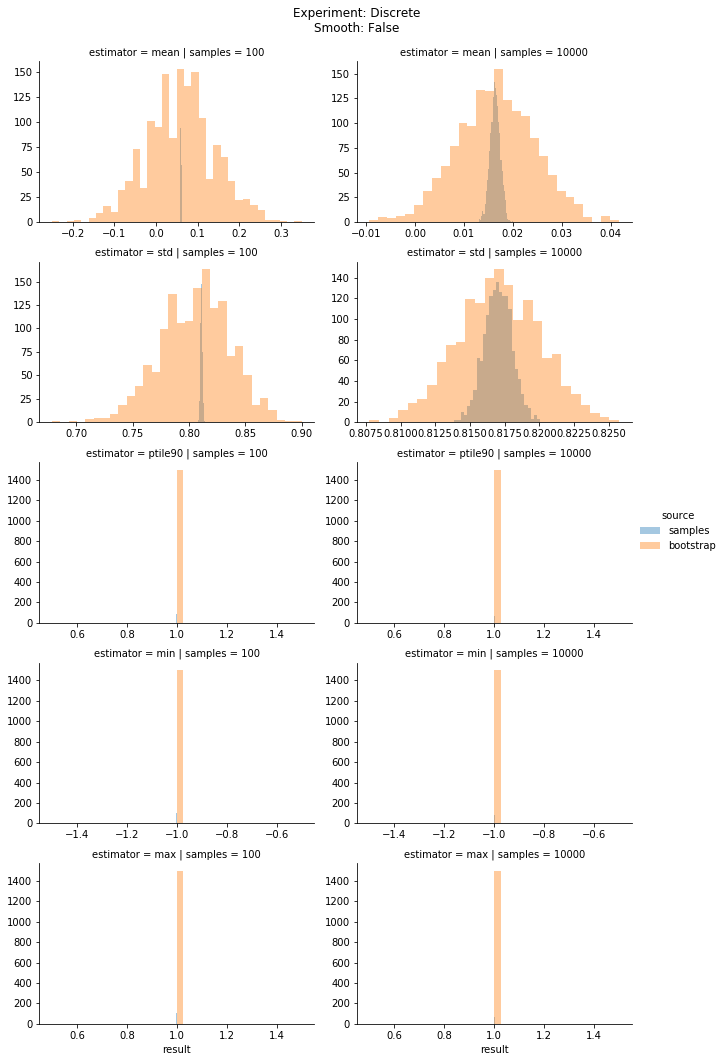

In [26]:
pdf = df[(df.experiment == "discrete") & (df.smooth == smooth)]
g = plot_facet(pdf, f"Experiment: Discrete\nSmooth: {smooth}")

There are some examples here where even 1.5k bootstraps is rather sparse in terms of the estimator results. We should be able to make these smoother by dithering the input samples upon each resample.

### bootstrap(samples) *vs.* bootstrap(smoothed)
Only bootstrapped data. Rows are the estimation, columns are the number of samples, and the hue compares the bootstrap estimation with and without smoothing.

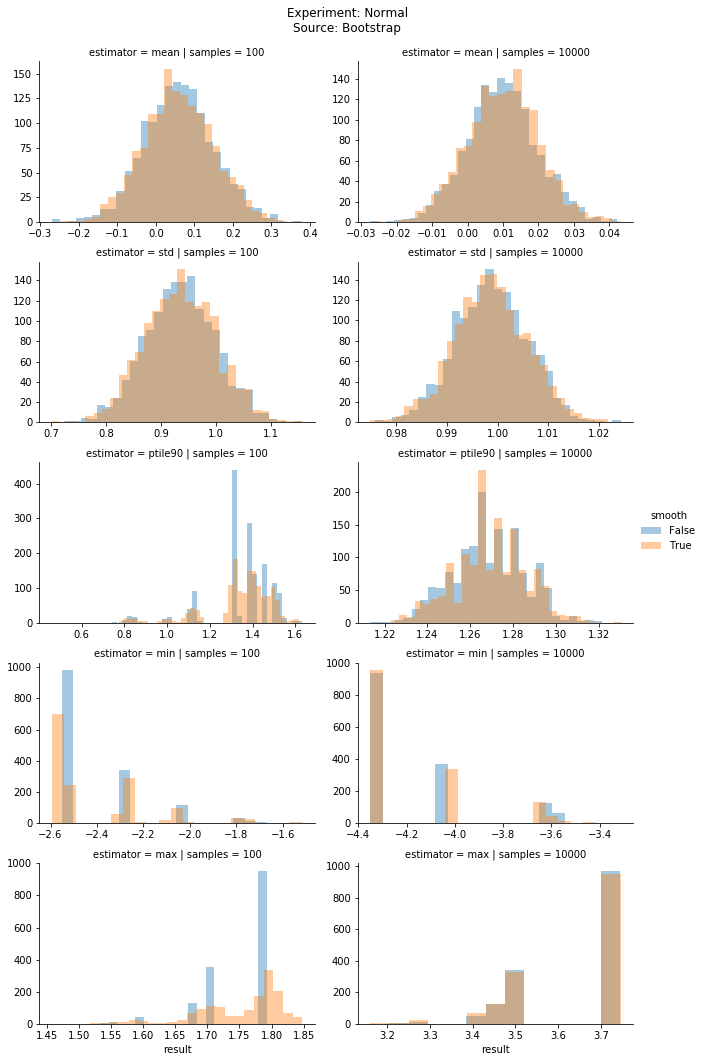

In [27]:
source = "bootstrap"
pdf = df[(df.experiment == "normal") & (df.source == source)]
g = plot_facet(pdf, f"Experiment: Normal\nSource: {source.title()}", hue="smooth")

In [28]:
pdf = df[(df.experiment == "uniform") & (df.source == source)]
g = plot_facet(pdf, f"Experiment: Uniform\nSource: {source.title()}", hue="smooth")

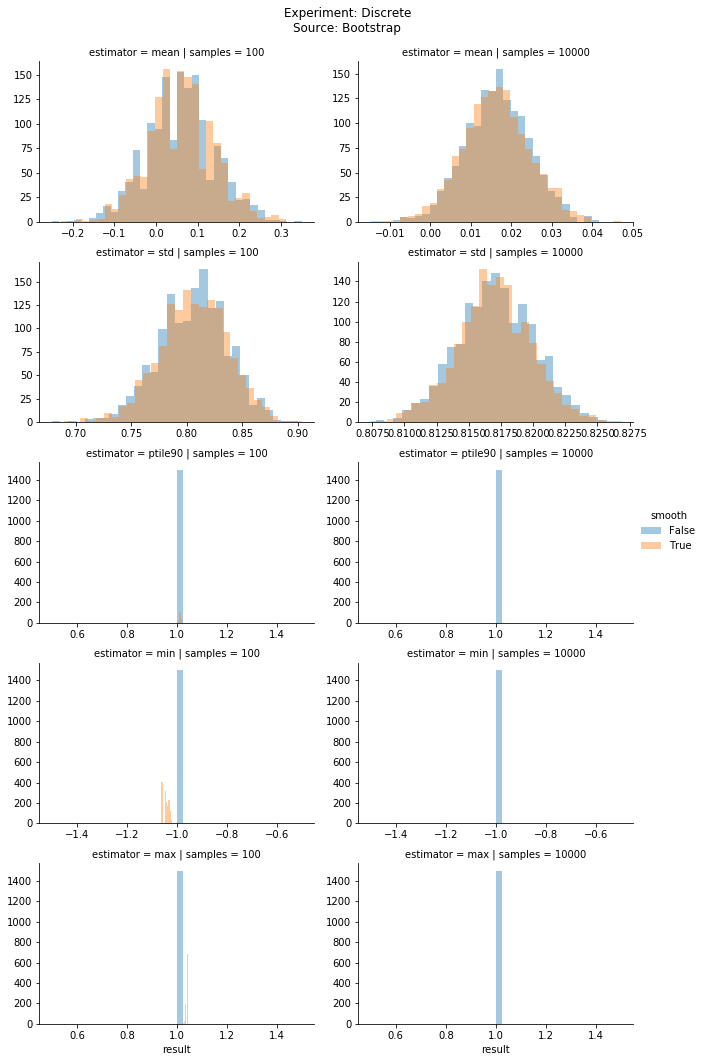

In [29]:
pdf = df[(df.experiment == "discrete") & (df.source == source)]
g = plot_facet(pdf, f"Experiment: Discrete\nSource: {source.title()}", hue="smooth")

There are some cases where smoothing has little effect (e.g. the mean of a normal distribution of 10k samples), but depending on the distribution of the experiment and the estimator, the output of the bootstrap estimation can be noticeably smooth (e.g. p90 of uniform distribution of 100 samples).